<h2><font face="SimSun" color="black">2.1 数据集的准备与介绍</font></h2>

下载MNIST数据集至本地后，通过上传文件导入至work文件夹下(data文件加下数据在notebook重新加载后无法保存)，使用gzip命令进行解压

In [1]:
!gzip -dfq work/t10k-labels-idx1-ubyte.gz
!gzip -dfq work/train-labels-idx1-ubyte.gz
!gzip -dfq work/t10k-images-idx3-ubyte.gz
!gzip -dfq work/train-images-idx3-ubyte.gz

In [2]:
!tree work -d
!ls work

work

0 directories
t10k-images-idx3-ubyte	train-images-idx3-ubyte
t10k-labels-idx1-ubyte	train-labels-idx1-ubyte


MNIST手写数字数据库，包含60000个样本的训练集和10000个样本的测试集

训练集图片文件为train-images-idx3-ubyte，标签文件为train-labels-idx1-ubyte，共包含60,000个样本，每个样本对应一个28 * 28像素的[0, 255]灰度图片，以及一个[0, 9]的标签

测试集图片文件为t10k-images-idx3-ubyte，标签文件为t10k-labels-idx1-ubyte，共包含10,000个样本，每个样本对应一个28 * 28像素的[0, 255]灰度图片，以及一个[0, 9]的标签

注1：
0表示白色，255表示黑色

注2：
文件格式为idx，前4个字节包含了文本信息——前2个字节置0，第3个字节为数据类型编码（0x08表示无符号字节[0, 255]），第4个字节为数据维度k（0x03表示3维）
    
之后每4个字节（int32）表示一个维度特征，共k个特征，即k个int32数据表示dim1, dim2...dimk
    
之后为数据主要内容，总数据量大小为$\prod_{i=1}^k dim_i$


<h2><font face="SimSun" color="black">2.2 数据集类的定义</font></h2>

自定义MyMNISTDataset类继承paddle.io.Dataset，并实现\_\_init\_\_, \_\_getitem\_\_，\_\_len\_\_方法

decode_idx3_ubyte和decode_idx1_ubyte方法分别完成图片和标签文件的解码，并返回numpy格式的图片数据和标签数据

In [3]:
import paddle
import numpy as np
import struct

class MyMNISTDataset(paddle.io.Dataset):
    def __init__(self, image_file, label_file):
        super(MyMNISTDataset, self).__init__()
        self.images = self.decode_idx3_ubyte(image_file)
        self.labels = self.decode_idx1_ubyte(label_file)
        self.length = len(self.labels)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.length

    def decode_idx3_ubyte(self, idx3_ubyte_file):
        bin_data = open(idx3_ubyte_file, 'rb').read()
        offset = 0
        fmt_header = '>iiii'
        magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
        image_size = num_rows * num_cols
        offset += struct.calcsize(fmt_header)
        fmt_image = '>' + str(image_size) + 'B'
        images = np.empty((num_images, num_rows, num_cols), dtype=np.uint8)
        for i in range(num_images):
            images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
            offset += struct.calcsize(fmt_image)
        return images

    def decode_idx1_ubyte(self,idx1_ubyte_file):
        bin_data = open(idx1_ubyte_file, 'rb').read()
        offset = 0
        fmt_header = '>ii'
        magic_number, num_labels = struct.unpack_from(fmt_header, bin_data, offset)
        offset += struct.calcsize(fmt_header)
        fmt_label = '>B'
        labels = np.empty(num_labels, dtype=np.uint8)
        for i in range(num_labels):
            labels[i] = struct.unpack_from(fmt_label, bin_data, offset)[0]
            offset += struct.calcsize(fmt_label)
        labels = np.expand_dims(labels, axis=-1)
        return labels

<h2><font face="SimSun" color="black">2.3 数据集类的测试</font></h2>

通过MyMNISTDataset类构造训练集和测试集，分别获得样本数据和标签数据，测试get、len方法，并用dataloader封装后测试batch效果

In [4]:
train_dataset = MyMNISTDataset("work/train-images-idx3-ubyte", "work/train-labels-idx1-ubyte")
print("训练集样本大小：", len(train_dataset))
print("训练集图片大小：", train_dataset.images.shape)
print("训练集标签大小：", train_dataset.labels.shape)
print("训练集第1个样本：", "\n标签：", train_dataset.labels[0], "\n图片：", train_dataset.images[0])
test_dataset = MyMNISTDataset("work/t10k-images-idx3-ubyte", "work/t10k-labels-idx1-ubyte")
print("测试集样本大小：", len(test_dataset))
print("测试集图片大小：", test_dataset.images.shape)
print("测试集标签大小：", test_dataset.labels.shape)
print("测试集第1个样本：", "\n标签：", test_dataset.labels[0], "\n图片：", test_dataset.images[0])

训练集样本大小： 60000
训练集图片大小： (60000, 28, 28)
训练集标签大小： (60000, 1)
训练集第1个样本： 
标签： [5] 
图片： [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39  

In [5]:
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=1024,
    shuffle=True,
    drop_last=False)
for step, data in enumerate(train_dataloader):
    image, label = data
    print("训练集batch数据:", step, image.shape, label.shape)
test_dataloader = paddle.io.DataLoader(
    test_dataset,
    batch_size=1024,
    shuffle=True,
    drop_last=False)
for step, data in enumerate(test_dataloader):
    image, label = data
    print("测试集batch数据:", step, image.shape, label.shape)

训练集batch数据: 0 [1024, 28, 28] [1024, 1]
训练集batch数据: 1 [1024, 28, 28] [1024, 1]
训练集batch数据: 2 [1024, 28, 28] [1024, 1]
训练集batch数据: 3 [1024, 28, 28] [1024, 1]
训练集batch数据: 4 [1024, 28, 28] [1024, 1]
训练集batch数据: 5 [1024, 28, 28] [1024, 1]
训练集batch数据: 6 [1024, 28, 28] [1024, 1]
训练集batch数据: 7 [1024, 28, 28] [1024, 1]
训练集batch数据: 8 [1024, 28, 28] [1024, 1]
训练集batch数据: 9 [1024, 28, 28] [1024, 1]
训练集batch数据: 10 [1024, 28, 28] [1024, 1]
训练集batch数据: 11 [1024, 28, 28] [1024, 1]
训练集batch数据: 12 [1024, 28, 28] [1024, 1]
训练集batch数据: 13 [1024, 28, 28] [1024, 1]
训练集batch数据: 14 [1024, 28, 28] [1024, 1]
训练集batch数据: 15 [1024, 28, 28] [1024, 1]
训练集batch数据: 16 [1024, 28, 28] [1024, 1]
训练集batch数据: 17 [1024, 28, 28] [1024, 1]
训练集batch数据: 18 [1024, 28, 28] [1024, 1]
训练集batch数据: 19 [1024, 28, 28] [1024, 1]
训练集batch数据: 20 [1024, 28, 28] [1024, 1]
训练集batch数据: 21 [1024, 28, 28] [1024, 1]
训练集batch数据: 22 [1024, 28, 28] [1024, 1]
训练集batch数据: 23 [1024, 28, 28] [1024, 1]
训练集batch数据: 24 [1024, 28, 28] [1024, 1]
训练集batch数据

<h2><font face="SimSun" color="black">2.4 图像/文本数据的统计分析</font></h2>

对训练集和测试集的第1个样本进行可视化展示

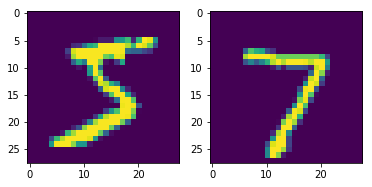

In [8]:
from matplotlib import pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(train_dataset.images[0])
plt.subplot(1, 2, 2)
plt.imshow(test_dataset.images[0])

对训练集和测试集的全量样本，分别进行图片数据整体均值和方差计算

In [7]:
import numpy as np

def get_mean_std(dataset):
    length = dataset.length
    print('图片数量:', length)
    max_val, min_val = np.zeros(length), np.ones(length) * 255
    mean, std = np.zeros(length), np.zeros(length)
    for i, image in enumerate(dataset.images):
        mean[i] += image[:, :].mean()
        std[i] += image[:, :].std()
        max_val[i] = max(max_val[i], image[:, :].max())
        min_val[i] = min(min_val[i], image[:, :].min())

    mean /= length
    std /= length

    mean /= max_val - min_val
    std /= max_val - min_val

    return mean, std

print("训练集：")
mean, std = get_mean_std(train_dataset)
mean = np.expand_dims(mean, axis=-1)
std = np.expand_dims(std, axis=-1)
print('图片均值:', mean)
print('图片方差:', std)

print("测试集：")
mean, std = get_mean_std(test_dataset)
mean = np.expand_dims(mean, axis=-1)
std = np.expand_dims(std, axis=-1)
print('图片均值:', mean)
print('图片方差:', std)

训练集：
图片数量: 60000
图片均值: [[2.29466787e-06]
 [2.59228691e-06]
 [1.62089836e-06]
 ...
 [1.84507136e-06]
 [1.70301454e-06]
 [1.74403095e-06]]
图片方差: [[5.20580581e-06]
 [5.48282083e-06]
 [4.28625813e-06]
 ...
 [4.67316103e-06]
 [4.34084402e-06]
 [4.41616400e-06]]
测试集：
图片数量: 10000
图片均值: [[9.23069228e-06]
 [1.44307723e-05]
 [4.93747499e-06]
 ...
 [1.46213485e-05]
 [1.32848139e-05]
 [2.10072513e-05]]
图片方差: [[2.58746550e-05]
 [3.21120091e-05]
 [1.91633675e-05]
 ...
 [3.28837808e-05]
 [3.10564274e-05]
 [3.76876851e-05]]
